In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm


In [8]:
if False:
    # Define the root directory where the dataset will be stored
    root_dir = "./data"

    # Download the CelebA dataset (including annotations)
    celeba_dataset = datasets.CelebA(root=root_dir, split="all", download=True)

    print("CelebA dataset downloaded successfully!")
    import os

    data_path = "./data/celeba"
    print("Dataset files:", os.listdir(data_path))

    import torchvision.datasets as datasets
    import torchvision.transforms as transforms
    from torch.utils.data import DataLoader

    # Define transformations: Convert images to tensors
    transform = transforms.Compose([
        transforms.ToTensor()  # Converts PIL Image to PyTorch Tensor
    ])

    # Load CelebA dataset with transforms

    # Create a DataLoader
    celeba_loader = DataLoader(celeba_dataset, batch_size=32, shuffle=True)

    if False:
        # Get a batch of images and labels
        images, labels = next(iter(celeba_loader))

        # Print batch shape
        print("Batch shape:", images.shape)  # Should be (32, 3, 218, 178)
    celeba_dataset = datasets.CelebA(root=DATA_DIR, split="all", download=True, transform=transform)


In [9]:
from torch.utils.data import DataLoader, Subset

BATCH_SIZE = 64  # Increase batch size for better training
NUM_WORKERS = 4
DATA_DIR = "data"



# ========================
# 2. DATA LOADING (WITH STRONG AUGMENTATION)
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


if True: # only for debugging - train on 30% of the training set
    TRAIN_SPLIT =VAL_SPLIT = 0.25
    # Get 30% indices
    train_size = int(TRAIN_SPLIT * len(train_dataset))
    val_size = int(VAL_SPLIT * len(val_dataset))
    import numpy as np

    # Randomly sample 30% of the indices
    train_indices = np.random.choice(len(train_dataset), train_size, replace=False)
    val_indices = np.random.choice(len(val_dataset), val_size, replace=False)

    # Create subset datasets
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)


    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)

Using device: cuda


In [11]:


# ========================
# 5. TRAINING FUNCTION
# ========================
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, SAVE_MODEL_PATH= None):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")
        # Validation
        validate(model, val_loader, criterion)
        evaluate(model, val_loader)
        scheduler.step()  # Update learning rate

        if SAVE_MODEL_PATH is not None:
            print(f"Saving model to {SAVE_MODEL_PATH}")
            # Save model checkpoint
            torch.save(model.state_dict(), SAVE_MODEL_PATH)

# ========================
# 6. VALIDATION FUNCTION
# ========================
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")

# ========================
# 7. EVALUATION FUNCTION
# ========================
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            logits = model(images)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds = (probs > 0.5).int()  # Threshold at 0.5 to get binary predictions

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    preds = torch.cat(all_preds)
    true_labels = torch.cat(all_labels)

    # Compute per-class accuracy
    per_class_accuracy = (preds == true_labels).float().mean(dim=0)

    # Compute overall accuracy (average across all attributes)
    overall_accuracy = per_class_accuracy.mean().item()

    # Print results
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    print(f"Per-attribute accuracy:\n{per_class_accuracy}")

    return per_class_accuracy, overall_accuracy

In [12]:

# ========================
# 1. CONFIGURATION
# ========================
#IMAGE_SIZE = 224
NUM_EPOCHS = 20  # More epochs needed
LEARNING_RATE = 0.01  # Higher initial LR when training from scratch
SAVE_MODEL_PATH = "resnet50_scratch_celeba.pth"


# ========================
# 3. MODEL DEFINITION (TRAINING FROM SCRATCH)
# ========================
model = models.resnet50(pretrained=False)  # Train from scratch
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
model = model.to(DEVICE)

# ========================
# 4. LOSS & OPTIMIZER
# ========================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)  # SGD with momentum

# Learning rate scheduler (reduce LR after plateaus)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epochs
# ========================
# 8. TRAIN & EVALUATE MODEL
# ========================
train(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, SAVE_MODEL_PATH=SAVE_MODEL_PATH)
evaluate(model, val_loader)


Epoch 1/20:   0%|          | 0/636 [00:00<?, ?it/s]/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/20: 100%|██████████| 636/636 [02:21<00:00,  4.50it/s]

Epoch 1 Loss: 0.4280


Validation Loss: 0.4178
Overall accuracy: 0.8149
Per-attribute accuracy:
tensor([0.8808, 0.7447, 0.5568, 0.7839, 0.9795, 0.8542, 0.8514, 0.7525, 0.7958,
        0.8478, 0.9497, 0.7525, 0.8584, 0.9418, 0.9525, 0.9319, 0.9249, 0.9515,
        0.6331, 0.5695, 0.6591, 0.5077, 0.9466, 0.9261, 0.8244, 0.7368, 0.9579,
        0.7116, 0.9358, 0.9325, 0.9346, 0.5491, 0.7876, 0.7273, 0.8164, 0.9525,
        0.6162, 0.8826, 0.9287, 0.7491])
Saving model to resnet50_scratch_celeba.pth


Epoch 2/20: 100%|██████████| 636/636 [02:14<00:00,  4.72it/s]

Epoch 2 Loss: 0.3999


Validation Loss: 0.3905
Overall accuracy: 0.8294
Per-attribute accuracy:
tensor([0.8806, 0.7404, 0.6637, 0.7839, 0.9795, 0.8542, 0.8498, 0.7517, 0.7978,
        0.8856, 0.9497, 0.7525, 0.8584, 0.9418, 0.9525, 0.9319, 0.9249, 0.9515,
        0.7392, 0.6091, 0.7523, 0.5397, 0.9466, 0.9261, 0.8252, 0.7370, 0.9579,
        0.7120, 0.9358, 0.9325, 0.9346, 0.5846, 0.7876, 0.7290, 0.8164, 0.9523,
        0.7422, 0.8826, 0.9287, 0.7555])
Saving model to resnet50_scratch_celeba.pth


Epoch 3/20: 100%|██████████| 636/636 [01:51<00:00,  5.70it/s]

Epoch 3 Loss: 0.3828


Validation Loss: 0.3750
Overall accuracy: 0.8348
Per-attribute accuracy:
tensor([0.8806, 0.7394, 0.6748, 0.7835, 0.9795, 0.8542, 0.8516, 0.7531, 0.8115,
        0.8915, 0.9497, 0.7580, 0.8582, 0.9416, 0.9525, 0.9319, 0.9249, 0.9517,
        0.7551, 0.6190, 0.7900, 0.5713, 0.9466, 0.9261, 0.8252, 0.7320, 0.9579,
        0.7130, 0.9358, 0.9323, 0.9346, 0.6041, 0.7876, 0.7533, 0.8129, 0.9527,
        0.7706, 0.8826, 0.9354, 0.7660])
Saving model to resnet50_scratch_celeba.pth


Epoch 4/20: 100%|██████████| 636/636 [01:50<00:00,  5.73it/s]

Epoch 4 Loss: 0.3696


Validation Loss: 0.3620
Overall accuracy: 0.8408
Per-attribute accuracy:
tensor([0.8806, 0.7422, 0.7022, 0.7815, 0.9795, 0.8542, 0.8490, 0.7563, 0.8331,
        0.9011, 0.9497, 0.7747, 0.8582, 0.9418, 0.9525, 0.9319, 0.9249, 0.9513,
        0.7769, 0.6418, 0.8200, 0.5826, 0.9466, 0.9261, 0.8278, 0.7350, 0.9581,
        0.7163, 0.9358, 0.9335, 0.9346, 0.6478, 0.7876, 0.7610, 0.8111, 0.9531,
        0.7872, 0.8826, 0.9370, 0.7656])
Saving model to resnet50_scratch_celeba.pth


Epoch 5/20: 100%|██████████| 636/636 [01:49<00:00,  5.82it/s]

Epoch 5 Loss: 0.3548


Validation Loss: 0.3444
Overall accuracy: 0.8491
Per-attribute accuracy:
tensor([0.8826, 0.7523, 0.7092, 0.7851, 0.9795, 0.8544, 0.8492, 0.7608, 0.8357,
        0.9108, 0.9497, 0.7735, 0.8605, 0.9420, 0.9539, 0.9319, 0.9251, 0.9539,
        0.8119, 0.6768, 0.8639, 0.6319, 0.9466, 0.9261, 0.8423, 0.7302, 0.9581,
        0.7116, 0.9358, 0.9333, 0.9348, 0.6957, 0.7876, 0.7596, 0.8157, 0.9537,
        0.8302, 0.8826, 0.9380, 0.7857])
Saving model to resnet50_scratch_celeba.pth


Epoch 6/20: 100%|██████████| 636/636 [01:51<00:00,  5.72it/s]

Epoch 6 Loss: 0.3304


Validation Loss: 0.3262
Overall accuracy: 0.8594
Per-attribute accuracy:
tensor([0.8907, 0.7561, 0.6992, 0.7795, 0.9754, 0.8558, 0.8516, 0.7712, 0.8637,
        0.9172, 0.9497, 0.7884, 0.8663, 0.9358, 0.9507, 0.9315, 0.9281, 0.9565,
        0.7747, 0.7735, 0.8838, 0.7513, 0.9468, 0.9261, 0.8564, 0.7348, 0.9581,
        0.7116, 0.9337, 0.9323, 0.9348, 0.8000, 0.7882, 0.7680, 0.8172, 0.9545,
        0.8341, 0.8822, 0.9456, 0.8002])
Saving model to resnet50_scratch_celeba.pth


Epoch 7/20: 100%|██████████| 636/636 [01:47<00:00,  5.90it/s]

Epoch 7 Loss: 0.3064


Validation Loss: 0.2917
Overall accuracy: 0.8742
Per-attribute accuracy:
tensor([0.8907, 0.7781, 0.7435, 0.7916, 0.9803, 0.8933, 0.8512, 0.7894, 0.8665,
        0.9223, 0.9497, 0.8097, 0.8717, 0.9394, 0.9535, 0.9319, 0.9327, 0.9569,
        0.8657, 0.8141, 0.9305, 0.7928, 0.9476, 0.9261, 0.8874, 0.7422, 0.9581,
        0.7257, 0.9382, 0.9356, 0.9398, 0.8584, 0.7878, 0.7582, 0.8246, 0.9617,
        0.8894, 0.8818, 0.9460, 0.8053])
Saving model to resnet50_scratch_celeba.pth


Epoch 8/20: 100%|██████████| 636/636 [01:51<00:00,  5.71it/s]

Epoch 8 Loss: 0.2897


Validation Loss: 0.2921
Overall accuracy: 0.8736
Per-attribute accuracy:
tensor([0.8947, 0.7829, 0.7088, 0.7958, 0.9797, 0.9203, 0.8516, 0.7739, 0.8677,
        0.9203, 0.9497, 0.8061, 0.8729, 0.9420, 0.9529, 0.9327, 0.9356, 0.9603,
        0.8574, 0.8194, 0.9174, 0.8115, 0.9468, 0.9261, 0.8923, 0.7366, 0.9595,
        0.7066, 0.9366, 0.9313, 0.9487, 0.8754, 0.7888, 0.7477, 0.8206, 0.9619,
        0.8693, 0.8822, 0.9448, 0.8147])
Saving model to resnet50_scratch_celeba.pth


Epoch 9/20: 100%|██████████| 636/636 [01:50<00:00,  5.75it/s]

Epoch 9 Loss: 0.2785


Validation Loss: 0.2764
Overall accuracy: 0.8799
Per-attribute accuracy:
tensor([0.8949, 0.7861, 0.7400, 0.7876, 0.9813, 0.9221, 0.8514, 0.7898, 0.8695,
        0.9152, 0.9497, 0.8079, 0.8822, 0.9408, 0.9561, 0.9458, 0.9382, 0.9611,
        0.8580, 0.8250, 0.9430, 0.8298, 0.9472, 0.9261, 0.9080, 0.7406, 0.9605,
        0.7130, 0.9364, 0.9364, 0.9464, 0.8764, 0.7886, 0.7884, 0.8345, 0.9684,
        0.8907, 0.8826, 0.9507, 0.8272])
Saving model to resnet50_scratch_celeba.pth


Epoch 10/20: 100%|██████████| 636/636 [01:51<00:00,  5.72it/s]

Epoch 10 Loss: 0.2692


Validation Loss: 0.2620
Overall accuracy: 0.8864
Per-attribute accuracy:
tensor([0.9037, 0.7988, 0.7531, 0.7958, 0.9813, 0.9333, 0.8518, 0.7920, 0.8844,
        0.9305, 0.9497, 0.8210, 0.8856, 0.9424, 0.9559, 0.9480, 0.9509, 0.9678,
        0.8814, 0.8347, 0.9507, 0.8514, 0.9468, 0.9261, 0.9132, 0.7525, 0.9591,
        0.7352, 0.9356, 0.9342, 0.9525, 0.8858, 0.7900, 0.8004, 0.8345, 0.9680,
        0.9017, 0.8800, 0.9487, 0.8262])
Saving model to resnet50_scratch_celeba.pth


Epoch 11/20: 100%|██████████| 636/636 [01:50<00:00,  5.77it/s]

Epoch 11 Loss: 0.2614


Validation Loss: 0.2546
Overall accuracy: 0.8900
Per-attribute accuracy:
tensor([0.9062, 0.7962, 0.7797, 0.8087, 0.9823, 0.9398, 0.8532, 0.7986, 0.8816,
        0.9303, 0.9497, 0.8216, 0.8993, 0.9430, 0.9573, 0.9601, 0.9487, 0.9642,
        0.8818, 0.8393, 0.9539, 0.8796, 0.9472, 0.9261, 0.9245, 0.7545, 0.9619,
        0.7344, 0.9331, 0.9382, 0.9533, 0.8959, 0.7938, 0.7845, 0.8387, 0.9718,
        0.8965, 0.8850, 0.9466, 0.8371])
Saving model to resnet50_scratch_celeba.pth


Epoch 12/20: 100%|██████████| 636/636 [01:50<00:00,  5.74it/s]

Epoch 12 Loss: 0.2538


Validation Loss: 0.2499
Overall accuracy: 0.8908
Per-attribute accuracy:
tensor([0.9054, 0.8043, 0.7773, 0.8079, 0.9803, 0.9319, 0.8556, 0.7890, 0.8727,
        0.9305, 0.9501, 0.8188, 0.8967, 0.9454, 0.9561, 0.9660, 0.9519, 0.9662,
        0.8834, 0.8458, 0.9521, 0.8927, 0.9464, 0.9263, 0.9257, 0.7561, 0.9611,
        0.7374, 0.9368, 0.9342, 0.9523, 0.8983, 0.7920, 0.8067, 0.8298, 0.9718,
        0.9035, 0.8828, 0.9478, 0.8411])
Saving model to resnet50_scratch_celeba.pth


Epoch 13/20: 100%|██████████| 636/636 [01:51<00:00,  5.72it/s]

Epoch 13 Loss: 0.2476


Validation Loss: 0.2457
Overall accuracy: 0.8938
Per-attribute accuracy:
tensor([0.9152, 0.8051, 0.7829, 0.8099, 0.9781, 0.9289, 0.8590, 0.8019, 0.8816,
        0.9239, 0.9493, 0.8258, 0.8933, 0.9434, 0.9585, 0.9740, 0.9555, 0.9660,
        0.8925, 0.8568, 0.9607, 0.9017, 0.9472, 0.9267, 0.9299, 0.7529, 0.9607,
        0.7362, 0.9380, 0.9392, 0.9561, 0.9023, 0.7908, 0.8172, 0.8415, 0.9694,
        0.9110, 0.8826, 0.9497, 0.8375])
Saving model to resnet50_scratch_celeba.pth


Epoch 14/20: 100%|██████████| 636/636 [01:48<00:00,  5.84it/s]

Epoch 14 Loss: 0.2430


Validation Loss: 0.2403
Overall accuracy: 0.8963
Per-attribute accuracy:
tensor([0.9150, 0.8057, 0.7700, 0.8161, 0.9817, 0.9376, 0.8617, 0.8039, 0.8882,
        0.9366, 0.9495, 0.8345, 0.9054, 0.9440, 0.9577, 0.9785, 0.9531, 0.9676,
        0.8987, 0.8582, 0.9676, 0.8973, 0.9464, 0.9279, 0.9309, 0.7592, 0.9605,
        0.7412, 0.9406, 0.9396, 0.9563, 0.9025, 0.7986, 0.8139, 0.8393, 0.9742,
        0.9102, 0.8828, 0.9507, 0.8470])
Saving model to resnet50_scratch_celeba.pth


Epoch 15/20: 100%|██████████| 636/636 [01:51<00:00,  5.70it/s]

Epoch 15 Loss: 0.2391


Validation Loss: 0.2350
Overall accuracy: 0.8975
Per-attribute accuracy:
tensor([0.9217, 0.8085, 0.7825, 0.8117, 0.9829, 0.9501, 0.8578, 0.8031, 0.8957,
        0.9348, 0.9513, 0.8236, 0.9098, 0.9450, 0.9593, 0.9783, 0.9559, 0.9692,
        0.9017, 0.8462, 0.9662, 0.9039, 0.9493, 0.9267, 0.9321, 0.7592, 0.9607,
        0.7392, 0.9412, 0.9398, 0.9577, 0.9060, 0.7940, 0.8236, 0.8387, 0.9801,
        0.9118, 0.8828, 0.9529, 0.8470])
Saving model to resnet50_scratch_celeba.pth


Epoch 16/20: 100%|██████████| 636/636 [01:49<00:00,  5.80it/s]

Epoch 16 Loss: 0.2322


Validation Loss: 0.2292
Overall accuracy: 0.9009
Per-attribute accuracy:
tensor([0.9215, 0.8170, 0.7938, 0.8180, 0.9821, 0.9476, 0.8635, 0.8071, 0.8933,
        0.9370, 0.9505, 0.8345, 0.9118, 0.9430, 0.9597, 0.9776, 0.9609, 0.9708,
        0.9039, 0.8629, 0.9692, 0.9144, 0.9470, 0.9291, 0.9378, 0.7598, 0.9629,
        0.7503, 0.9416, 0.9412, 0.9605, 0.9100, 0.7988, 0.8282, 0.8490, 0.9823,
        0.9080, 0.8832, 0.9527, 0.8532])
Saving model to resnet50_scratch_celeba.pth


Epoch 17/20: 100%|██████████| 636/636 [01:52<00:00,  5.66it/s]

Epoch 17 Loss: 0.2308


Validation Loss: 0.2291
Overall accuracy: 0.9006
Per-attribute accuracy:
tensor([0.9217, 0.8184, 0.7910, 0.8123, 0.9821, 0.9484, 0.8625, 0.8073, 0.8973,
        0.9384, 0.9501, 0.8329, 0.9104, 0.9460, 0.9613, 0.9789, 0.9609, 0.9688,
        0.9017, 0.8602, 0.9712, 0.9146, 0.9464, 0.9259, 0.9378, 0.7596, 0.9621,
        0.7477, 0.9410, 0.9438, 0.9597, 0.9076, 0.8006, 0.8232, 0.8484, 0.9833,
        0.9104, 0.8834, 0.9517, 0.8564])
Saving model to resnet50_scratch_celeba.pth


Epoch 18/20: 100%|██████████| 636/636 [01:50<00:00,  5.78it/s]

Epoch 18 Loss: 0.2304


Validation Loss: 0.2289
Overall accuracy: 0.9009
Per-attribute accuracy:
tensor([0.9229, 0.8145, 0.7882, 0.8155, 0.9827, 0.9452, 0.8629, 0.8059, 0.8971,
        0.9374, 0.9497, 0.8317, 0.9136, 0.9450, 0.9603, 0.9791, 0.9591, 0.9692,
        0.9025, 0.8613, 0.9664, 0.9184, 0.9482, 0.9273, 0.9380, 0.7588, 0.9617,
        0.7521, 0.9408, 0.9438, 0.9597, 0.9124, 0.8004, 0.8258, 0.8508, 0.9841,
        0.9128, 0.8830, 0.9521, 0.8558])
Saving model to resnet50_scratch_celeba.pth


Epoch 19/20: 100%|██████████| 636/636 [01:44<00:00,  6.08it/s]

Epoch 19 Loss: 0.2299


Validation Loss: 0.2278
Overall accuracy: 0.9016
Per-attribute accuracy:
tensor([0.9239, 0.8115, 0.7978, 0.8147, 0.9819, 0.9484, 0.8623, 0.8087, 0.8997,
        0.9400, 0.9509, 0.8391, 0.9116, 0.9460, 0.9621, 0.9803, 0.9599, 0.9718,
        0.8993, 0.8615, 0.9688, 0.9142, 0.9480, 0.9287, 0.9394, 0.7620, 0.9627,
        0.7477, 0.9420, 0.9436, 0.9573, 0.9072, 0.8017, 0.8300, 0.8500, 0.9827,
        0.9128, 0.8838, 0.9555, 0.8542])
Saving model to resnet50_scratch_celeba.pth


Epoch 20/20: 100%|██████████| 636/636 [01:51<00:00,  5.71it/s]

Epoch 20 Loss: 0.2295


Validation Loss: 0.2288
Overall accuracy: 0.9013
Per-attribute accuracy:
tensor([0.9211, 0.8157, 0.7986, 0.8182, 0.9817, 0.9480, 0.8659, 0.8063, 0.8939,
        0.9378, 0.9497, 0.8395, 0.9102, 0.9456, 0.9593, 0.9803, 0.9581, 0.9684,
        0.9046, 0.8598, 0.9710, 0.9209, 0.9474, 0.9279, 0.9440, 0.7586, 0.9640,
        0.7465, 0.9428, 0.9422, 0.9605, 0.9108, 0.8014, 0.8226, 0.8492, 0.9831,
        0.9076, 0.8846, 0.9521, 0.8506])
Saving model to resnet50_scratch_celeba.pth
Overall accuracy: 0.9012
Per-attribute accuracy:
tensor([0.9205, 0.8153, 0.7966, 0.8166, 0.9825, 0.9515, 0.8627, 0.8059, 0.9003,
        0.9370, 0.9501, 0.8413, 0.9092, 0.9446, 0.9595, 0.9805, 0.9603, 0.9680,
        0.9009, 0.8613, 0.9692, 0.9201, 0.9493, 0.9277, 0.9388, 0.7571, 0.9631,
        0.7533, 0.9396, 0.9426, 0.9613, 0.9100, 0.7990, 0.8212, 0.8486, 0.9821,
        0.9106, 0.8832, 0.9517, 0.8544])


(tensor([0.9205, 0.8153, 0.7966, 0.8166, 0.9825, 0.9515, 0.8627, 0.8059, 0.9003,
         0.9370, 0.9501, 0.8413, 0.9092, 0.9446, 0.9595, 0.9805, 0.9603, 0.9680,
         0.9009, 0.8613, 0.9692, 0.9201, 0.9493, 0.9277, 0.9388, 0.7571, 0.9631,
         0.7533, 0.9396, 0.9426, 0.9613, 0.9100, 0.7990, 0.8212, 0.8486, 0.9821,
         0.9106, 0.8832, 0.9517, 0.8544]),
 0.901183009147644)

In [15]:
#labels[0]
# Extract targets manually
subset_targets = []
for i in range(len(train_dataset)):
    if i % 10_000 == 0:
        print("Processing sample", i)
    subset_targets.append(train_dataset[i][1])

subset_targets = torch.stack(subset_targets)

Processing sample 0
Processing sample 10000
Processing sample 20000
Processing sample 30000
Processing sample 40000


['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


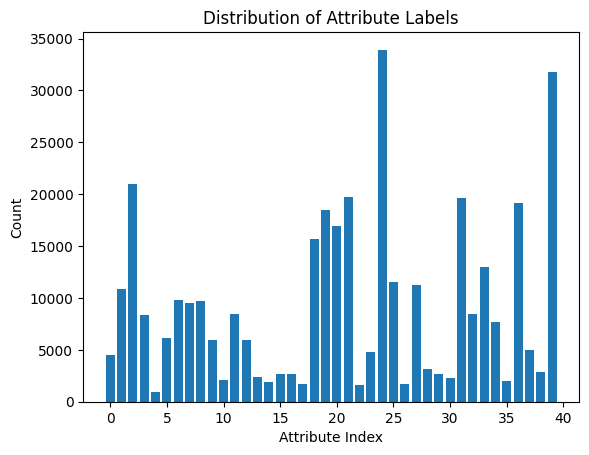

In [16]:
# 1 identify labels of attributes
#attribute_labels = 
print(train_dataset.dataset.attr_names)
# print histogram of labels
import matplotlib.pyplot as plt

import numpy as np

counts = np.sum(subset_targets.numpy(), axis=0)
counts
# plot bar chart of counts
plt.bar(range(len(counts)), counts)
plt.xlabel("Attribute Index")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.show()

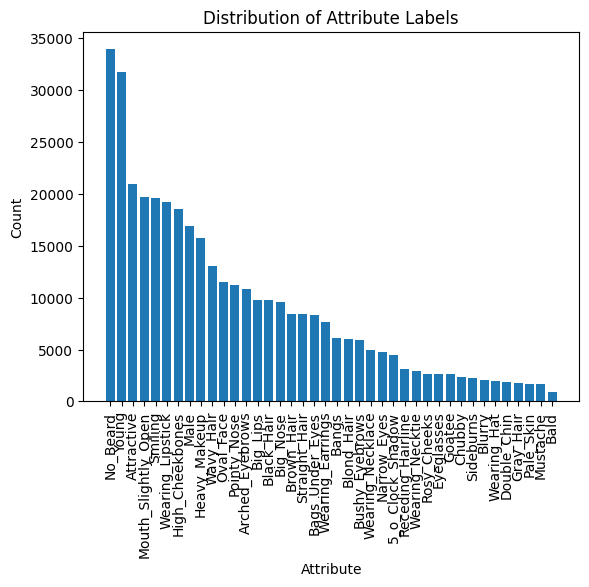

In [17]:
attribute_to_count = {train_dataset.dataset.attr_names[i] : counts[i] for i in range(len(counts))}
# Sort attributes by count
sorted_attributes = sorted(attribute_to_count.items(), key=lambda x: x[1], reverse=True)
# Print sorted attributes
#for attr, count in sorted_attributes:
#    print(f"{attr}: \t\t {count}")
# plot sorted attributes with counts, with text annotainos
x_axis = [attr for attr, count in sorted_attributes]
y_axis = [count for attr, count in sorted_attributes]
plt.bar(x_axis, y_axis)
plt.xlabel("Attribute")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.xticks(rotation=90)
plt.show()

In [18]:
subset_targets_np = subset_targets.numpy()

correlation_matrix = np.corrcoef(subset_targets_np, rowvar=False)
correlation_matrix.shape

(40, 40)

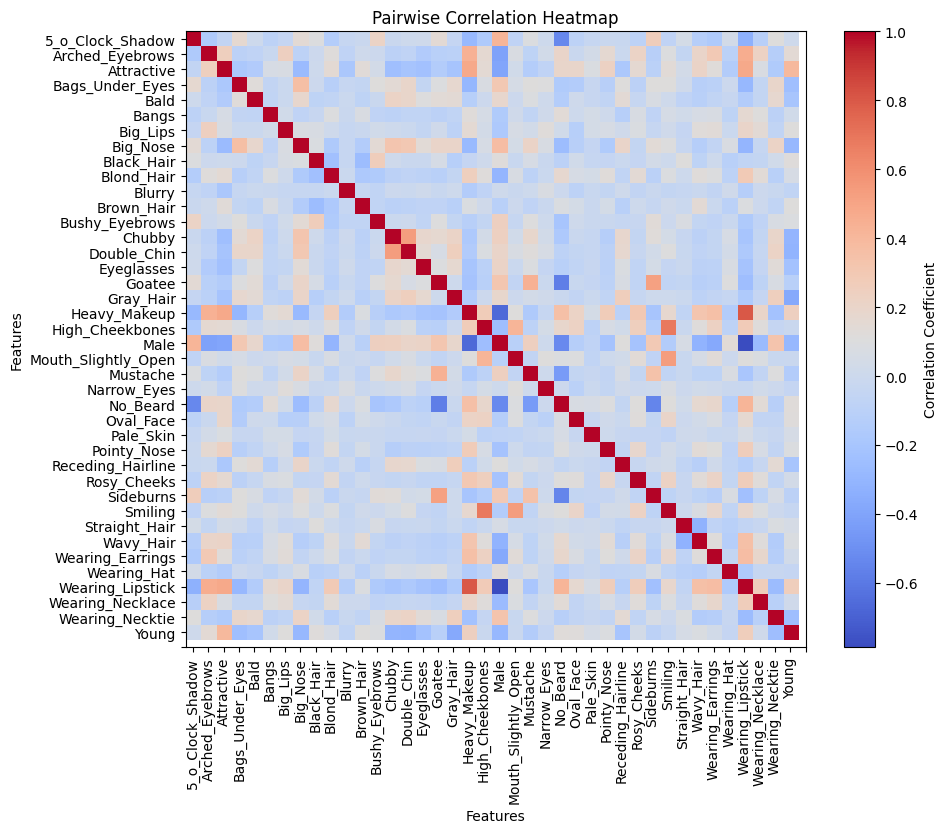

In [19]:
import matplotlib.pyplot as plt
attr_names = train_dataset.dataset.attr_names

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Correlation Coefficient")

# Set x and y ticks
plt.xticks(ticks=range(len(attr_names)), labels=attr_names, rotation=90)
plt.yticks(ticks=range(len(attr_names)), labels=attr_names)

plt.title("Pairwise Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()


In [21]:
average_correlation = np.mean(correlation_matrix, axis=1)
attribute_to_correlation = {train_dataset.dataset.attr_names[i] : correlation_matrix[i] for i in range(len(correlation_matrix))}
# Sort attributes by average correlation
sorted_attributes = sorted(attribute_to_correlation.items(), key=lambda x: np.mean(x[1]), reverse=True)
# Print sorted attributes
for attr, correlation in sorted_attributes:
    print(f"{attr}: \t\t {np.mean(correlation):.4f}")

Smiling: 		 0.0926
High_Cheekbones: 		 0.0878
Mouth_Slightly_Open: 		 0.0690
Rosy_Cheeks: 		 0.0645
Heavy_Makeup: 		 0.0618
Arched_Eyebrows: 		 0.0604
Wearing_Earrings: 		 0.0559
Wearing_Lipstick: 		 0.0558
Big_Lips: 		 0.0552
Double_Chin: 		 0.0535
Big_Nose: 		 0.0532
Chubby: 		 0.0500
Wearing_Necklace: 		 0.0457
Attractive: 		 0.0421
Pointy_Nose: 		 0.0372
Narrow_Eyes: 		 0.0362
Oval_Face: 		 0.0346
Wavy_Hair: 		 0.0345
Mustache: 		 0.0342
Bags_Under_Eyes: 		 0.0341
Receding_Hairline: 		 0.0331
Bushy_Eyebrows: 		 0.0316
Bald: 		 0.0301
Wearing_Necktie: 		 0.0300
Goatee: 		 0.0278
Gray_Hair: 		 0.0252
Blond_Hair: 		 0.0248
Sideburns: 		 0.0236
Bangs: 		 0.0219
Black_Hair: 		 0.0176
Pale_Skin: 		 0.0143
Straight_Hair: 		 0.0085
Eyeglasses: 		 0.0069
Brown_Hair: 		 0.0023
5_o_Clock_Shadow: 		 0.0021
Young: 		 -0.0011
No_Beard: 		 -0.0045
Wearing_Hat: 		 -0.0059
Blurry: 		 -0.0078
Male: 		 -0.0234


In [22]:
attribute_ = "Bags_Under_Eyes"
attr_index = train_dataset.dataset.attr_names.index(attribute_)
attr_index

indices_without_attr = np.where(subset_targets_np[:, attr_index] == 0)[0]
print("Number of samples without attribute:", len(indices_without_attr))

dataset_without_attribute = Subset(train_dataset, indices_without_attr)
len(dataset_without_attribute)
# train on dataset without attribute

train_loader_without_attr = DataLoader(dataset_without_attribute, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)



Number of samples without attribute: 32335


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
#


# ========================
# 1. CONFIGURATION
# ========================
#IMAGE_SIZE = 224
NUM_EPOCHS = 20  # More epochs needed
LEARNING_RATE = 0.01  # Higher initial LR when training from scratch
SAVE_MODEL_PATH = f"resnet50_scratch_celeba__remove_{attribute_}.pth"


# ========================
# 3. MODEL DEFINITION (TRAINING FROM SCRATCH)
# ========================
model_without_attr = models.resnet50(pretrained=False)  # Train from scratch
num_ftrs = model_without_attr.fc.in_features
model_without_attr.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
model_without_attr = model_without_attr.to(DEVICE)

# ========================
# 4. LOSS & OPTIMIZER
# ========================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_without_attr.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)  # SGD with momentum

# Learning rate scheduler (reduce LR after plateaus)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epochs
# ========================
# 8. TRAIN & EVALUATE MODEL
# ========================
train(model_without_attr, train_loader_without_attr, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, SAVE_MODEL_PATH=SAVE_MODEL_PATH)
evaluate(model_without_attr, val_loader)

Epoch 1/20: 100%|█████████▉| 504/506 [01:23<00:00, 10.11it/s]/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/20: 100%|██████████| 506/506 [01:25<00:00,  5.93it/s]

Epoch 1 Loss: 0.4047


Validation Loss: 0.4702
Overall accuracy: 0.8111
Per-attribute accuracy:
tensor([0.8808, 0.7465, 0.5532, 0.7839, 0.9795, 0.8542, 0.8516, 0.7525, 0.7940,
        0.8429, 0.9497, 0.7525, 0.8584, 0.9418, 0.9525, 0.9319, 0.9249, 0.9515,
        0.6295, 0.5467, 0.5872, 0.5385, 0.9466, 0.9261, 0.8256, 0.7261, 0.9579,
        0.7116, 0.9358, 0.9325, 0.9346, 0.5167, 0.7876, 0.7332, 0.8164, 0.9513,
        0.5759, 0.8826, 0.9287, 0.7497])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 2/20: 100%|██████████| 506/506 [01:20<00:00,  6.31it/s]

Epoch 2 Loss: 0.3852


Validation Loss: 0.4499
Overall accuracy: 0.8252
Per-attribute accuracy:
tensor([0.8808, 0.7382, 0.6492, 0.7839, 0.9795, 0.8542, 0.8512, 0.7523, 0.7799,
        0.8719, 0.9497, 0.7527, 0.8584, 0.9418, 0.9525, 0.9319, 0.9249, 0.9515,
        0.7124, 0.6055, 0.6865, 0.5546, 0.9466, 0.9261, 0.8256, 0.7366, 0.9579,
        0.7096, 0.9358, 0.9325, 0.9346, 0.5892, 0.7876, 0.7485, 0.8161, 0.9525,
        0.6863, 0.8826, 0.9287, 0.7491])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 3/20: 100%|██████████| 506/506 [01:20<00:00,  6.32it/s]

Epoch 3 Loss: 0.3655


Validation Loss: 0.4305
Overall accuracy: 0.8314
Per-attribute accuracy:
tensor([0.8808, 0.7477, 0.6816, 0.7839, 0.9795, 0.8542, 0.8516, 0.7525, 0.7855,
        0.8886, 0.9497, 0.7648, 0.8584, 0.9418, 0.9525, 0.9319, 0.9249, 0.9515,
        0.7608, 0.6035, 0.7708, 0.5334, 0.9466, 0.9261, 0.8246, 0.7368, 0.9579,
        0.7139, 0.9358, 0.9323, 0.9346, 0.5560, 0.7876, 0.7537, 0.8164, 0.9525,
        0.7710, 0.8826, 0.9283, 0.7493])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 4/20: 100%|██████████| 506/506 [01:22<00:00,  6.14it/s]

Epoch 4 Loss: 0.3498


Validation Loss: 0.4166
Overall accuracy: 0.8393
Per-attribute accuracy:
tensor([0.8808, 0.7485, 0.6826, 0.7839, 0.9795, 0.8542, 0.8504, 0.7527, 0.8059,
        0.8995, 0.9497, 0.7716, 0.8584, 0.9418, 0.9525, 0.9319, 0.9249, 0.9517,
        0.7926, 0.6615, 0.8226, 0.6087, 0.9466, 0.9261, 0.8250, 0.7334, 0.9579,
        0.7128, 0.9358, 0.9295, 0.9346, 0.6253, 0.7876, 0.7205, 0.8153, 0.9519,
        0.7994, 0.8824, 0.9299, 0.7511])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 5/20: 100%|██████████| 506/506 [01:21<00:00,  6.22it/s]

Epoch 5 Loss: 0.3293


Validation Loss: 0.3852
Overall accuracy: 0.8543
Per-attribute accuracy:
tensor([0.8824, 0.7608, 0.7098, 0.7839, 0.9795, 0.8542, 0.8516, 0.7630, 0.8389,
        0.9094, 0.9497, 0.7859, 0.8596, 0.9416, 0.9523, 0.9342, 0.9253, 0.9519,
        0.8335, 0.7324, 0.8792, 0.6907, 0.9466, 0.9261, 0.8315, 0.7358, 0.9579,
        0.7114, 0.9358, 0.9344, 0.9346, 0.7310, 0.7876, 0.7642, 0.8206, 0.9503,
        0.8552, 0.8826, 0.9321, 0.7630])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 6/20: 100%|██████████| 506/506 [01:20<00:00,  6.29it/s]

Epoch 6 Loss: 0.3092


Validation Loss: 0.3683
Overall accuracy: 0.8623
Per-attribute accuracy:
tensor([0.8852, 0.7672, 0.7247, 0.7839, 0.9795, 0.8542, 0.8516, 0.7598, 0.8625,
        0.9166, 0.9497, 0.7870, 0.8667, 0.9406, 0.9531, 0.9340, 0.9251, 0.9525,
        0.8550, 0.7751, 0.9054, 0.7529, 0.9462, 0.9261, 0.8466, 0.7183, 0.9579,
        0.7143, 0.9358, 0.9340, 0.9340, 0.8047, 0.7878, 0.7515, 0.8228, 0.9533,
        0.8756, 0.8826, 0.9362, 0.7845])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 7/20: 100%|██████████| 506/506 [01:20<00:00,  6.26it/s]

Epoch 7 Loss: 0.2933


Validation Loss: 0.3517
Overall accuracy: 0.8681
Per-attribute accuracy:
tensor([0.8896, 0.7809, 0.7418, 0.7839, 0.9795, 0.8542, 0.8512, 0.7718, 0.8687,
        0.9170, 0.9497, 0.7841, 0.8669, 0.9416, 0.9523, 0.9362, 0.9259, 0.9543,
        0.8671, 0.7884, 0.9221, 0.7841, 0.9464, 0.9261, 0.8621, 0.7354, 0.9579,
        0.7169, 0.9358, 0.9352, 0.9348, 0.8363, 0.7894, 0.7424, 0.8270, 0.9533,
        0.8903, 0.8826, 0.9408, 0.8002])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 8/20: 100%|██████████| 506/506 [01:20<00:00,  6.30it/s]

Epoch 8 Loss: 0.2814


Validation Loss: 0.3404
Overall accuracy: 0.8748
Per-attribute accuracy:
tensor([0.8917, 0.7849, 0.7616, 0.7839, 0.9795, 0.8814, 0.8317, 0.7821, 0.8625,
        0.9217, 0.9497, 0.8133, 0.8721, 0.9422, 0.9537, 0.9440, 0.9305, 0.9577,
        0.8723, 0.8113, 0.9313, 0.8063, 0.9468, 0.9261, 0.8814, 0.7380, 0.9583,
        0.7259, 0.9380, 0.9378, 0.9426, 0.8637, 0.7884, 0.7702, 0.8276, 0.9583,
        0.8939, 0.8828, 0.9400, 0.8077])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 9/20: 100%|██████████| 506/506 [01:21<00:00,  6.19it/s]

Epoch 9 Loss: 0.2720


Validation Loss: 0.3388
Overall accuracy: 0.8745
Per-attribute accuracy:
tensor([0.8896, 0.7602, 0.7610, 0.7839, 0.9795, 0.9031, 0.8476, 0.7725, 0.8715,
        0.9277, 0.9497, 0.8075, 0.8800, 0.9422, 0.9531, 0.9462, 0.9325, 0.9557,
        0.8605, 0.8198, 0.9156, 0.8286, 0.9470, 0.9261, 0.8792, 0.7259, 0.9601,
        0.7153, 0.9386, 0.9354, 0.9382, 0.8645, 0.7880, 0.7727, 0.8397, 0.9589,
        0.8774, 0.8820, 0.9422, 0.8012])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 10/20: 100%|██████████| 506/506 [01:21<00:00,  6.17it/s]

Epoch 10 Loss: 0.2641


Validation Loss: 0.3284
Overall accuracy: 0.8787
Per-attribute accuracy:
tensor([0.8965, 0.7870, 0.7596, 0.7839, 0.9797, 0.9170, 0.8516, 0.7571, 0.8687,
        0.9251, 0.9497, 0.8159, 0.8832, 0.9420, 0.9529, 0.9563, 0.9342, 0.9591,
        0.8784, 0.8214, 0.9319, 0.8407, 0.9456, 0.9261, 0.8892, 0.7447, 0.9593,
        0.7185, 0.9410, 0.9404, 0.9424, 0.8758, 0.7912, 0.7745, 0.8226, 0.9613,
        0.8955, 0.8826, 0.9466, 0.7976])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 11/20: 100%|██████████| 506/506 [01:20<00:00,  6.31it/s]

Epoch 11 Loss: 0.2561


Validation Loss: 0.3170
Overall accuracy: 0.8831
Per-attribute accuracy:
tensor([0.9017, 0.7918, 0.7499, 0.7839, 0.9799, 0.9299, 0.8508, 0.7775, 0.8776,
        0.9291, 0.9497, 0.8232, 0.8864, 0.9430, 0.9547, 0.9607, 0.9466, 0.9609,
        0.8743, 0.8194, 0.9295, 0.8586, 0.9478, 0.9261, 0.8957, 0.7473, 0.9619,
        0.7304, 0.9380, 0.9384, 0.9491, 0.8814, 0.7896, 0.7904, 0.8381, 0.9648,
        0.8896, 0.8828, 0.9478, 0.8254])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 12/20: 100%|██████████| 506/506 [01:20<00:00,  6.28it/s]

Epoch 12 Loss: 0.2499


Validation Loss: 0.3119
Overall accuracy: 0.8850
Per-attribute accuracy:
tensor([0.9064, 0.7920, 0.7666, 0.7839, 0.9797, 0.9271, 0.8518, 0.7857, 0.8854,
        0.9251, 0.9499, 0.8196, 0.8913, 0.9436, 0.9567, 0.9650, 0.9468, 0.9589,
        0.8776, 0.8321, 0.9406, 0.8752, 0.9468, 0.9261, 0.8961, 0.7275, 0.9597,
        0.7253, 0.9390, 0.9386, 0.9458, 0.8884, 0.7878, 0.8006, 0.8405, 0.9716,
        0.8981, 0.8826, 0.9466, 0.8192])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 13/20: 100%|██████████| 506/506 [01:21<00:00,  6.22it/s]

Epoch 13 Loss: 0.2436


Validation Loss: 0.3085
Overall accuracy: 0.8870
Per-attribute accuracy:
tensor([0.9043, 0.7976, 0.7720, 0.7839, 0.9805, 0.9362, 0.8512, 0.7966, 0.8735,
        0.9325, 0.9501, 0.8234, 0.8937, 0.9448, 0.9571, 0.9684, 0.9446, 0.9589,
        0.8820, 0.8373, 0.9414, 0.8850, 0.9464, 0.9261, 0.9168, 0.7431, 0.9611,
        0.7338, 0.9408, 0.9424, 0.9501, 0.8874, 0.7874, 0.7690, 0.8411, 0.9728,
        0.9019, 0.8800, 0.9460, 0.8198])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 14/20: 100%|██████████| 506/506 [01:21<00:00,  6.17it/s]

Epoch 14 Loss: 0.2394


Validation Loss: 0.3049
Overall accuracy: 0.8882
Per-attribute accuracy:
tensor([0.8991, 0.8033, 0.7686, 0.7839, 0.9809, 0.9350, 0.8566, 0.7829, 0.8304,
        0.9315, 0.9505, 0.8248, 0.8927, 0.9442, 0.9537, 0.9785, 0.9436, 0.9629,
        0.8840, 0.8419, 0.9456, 0.9003, 0.9476, 0.9261, 0.9120, 0.7463, 0.9611,
        0.7322, 0.9404, 0.9414, 0.9515, 0.9013, 0.7912, 0.8105, 0.8447, 0.9742,
        0.8971, 0.8826, 0.9487, 0.8234])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 15/20: 100%|██████████| 506/506 [01:21<00:00,  6.23it/s]

Epoch 15 Loss: 0.2345


Validation Loss: 0.2988
Overall accuracy: 0.8902
Per-attribute accuracy:
tensor([0.8969, 0.8025, 0.7847, 0.7839, 0.9803, 0.9356, 0.8514, 0.7918, 0.8866,
        0.9317, 0.9505, 0.8260, 0.9015, 0.9458, 0.9563, 0.9783, 0.9541, 0.9623,
        0.8977, 0.8353, 0.9511, 0.9021, 0.9456, 0.9261, 0.9241, 0.7376, 0.9613,
        0.7342, 0.9422, 0.9356, 0.9519, 0.8886, 0.7918, 0.7751, 0.8429, 0.9758,
        0.9060, 0.8782, 0.9503, 0.8347])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 16/20: 100%|██████████| 506/506 [01:22<00:00,  6.13it/s]

Epoch 16 Loss: 0.2284


Validation Loss: 0.2900
Overall accuracy: 0.8938
Per-attribute accuracy:
tensor([0.9082, 0.8051, 0.7861, 0.7839, 0.9817, 0.9410, 0.8590, 0.7874, 0.8872,
        0.9327, 0.9499, 0.8327, 0.9033, 0.9470, 0.9569, 0.9819, 0.9539, 0.9636,
        0.8965, 0.8431, 0.9599, 0.9041, 0.9460, 0.9261, 0.9231, 0.7459, 0.9623,
        0.7382, 0.9402, 0.9466, 0.9517, 0.9031, 0.7926, 0.8131, 0.8458, 0.9752,
        0.9088, 0.8828, 0.9454, 0.8417])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 17/20: 100%|██████████| 506/506 [01:21<00:00,  6.17it/s]

Epoch 17 Loss: 0.2270


Validation Loss: 0.2899
Overall accuracy: 0.8942
Per-attribute accuracy:
tensor([0.9064, 0.8083, 0.7865, 0.7839, 0.9801, 0.9434, 0.8578, 0.7880, 0.8913,
        0.9350, 0.9507, 0.8347, 0.9037, 0.9454, 0.9549, 0.9795, 0.9525, 0.9629,
        0.8929, 0.8453, 0.9605, 0.9086, 0.9468, 0.9261, 0.9243, 0.7455, 0.9627,
        0.7388, 0.9400, 0.9472, 0.9507, 0.9005, 0.7928, 0.8149, 0.8498, 0.9778,
        0.9062, 0.8828, 0.9509, 0.8363])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 18/20: 100%|██████████| 506/506 [01:22<00:00,  6.14it/s]

Epoch 18 Loss: 0.2265


Validation Loss: 0.2898
Overall accuracy: 0.8936
Per-attribute accuracy:
tensor([0.9102, 0.8045, 0.7819, 0.7839, 0.9797, 0.9430, 0.8570, 0.7865, 0.8913,
        0.9333, 0.9499, 0.8313, 0.9080, 0.9442, 0.9555, 0.9787, 0.9529, 0.9631,
        0.8963, 0.8472, 0.9577, 0.9046, 0.9456, 0.9261, 0.9223, 0.7451, 0.9615,
        0.7400, 0.9392, 0.9410, 0.9533, 0.9031, 0.7940, 0.8061, 0.8480, 0.9766,
        0.9102, 0.8824, 0.9497, 0.8405])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 19/20: 100%|██████████| 506/506 [01:21<00:00,  6.19it/s]

Epoch 19 Loss: 0.2264


Validation Loss: 0.2903
Overall accuracy: 0.8941
Per-attribute accuracy:
tensor([0.9116, 0.7998, 0.7880, 0.7839, 0.9807, 0.9426, 0.8560, 0.7878, 0.8935,
        0.9376, 0.9505, 0.8296, 0.9041, 0.9446, 0.9555, 0.9791, 0.9533, 0.9619,
        0.8939, 0.8500, 0.9613, 0.9031, 0.9464, 0.9261, 0.9253, 0.7485, 0.9638,
        0.7366, 0.9424, 0.9424, 0.9513, 0.9084, 0.7920, 0.8067, 0.8482, 0.9774,
        0.9078, 0.8830, 0.9484, 0.8393])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth


Epoch 20/20: 100%|██████████| 506/506 [01:20<00:00,  6.31it/s]

Epoch 20 Loss: 0.2255


Validation Loss: 0.2882
Overall accuracy: 0.8950
Per-attribute accuracy:
tensor([0.9078, 0.8065, 0.7906, 0.7839, 0.9813, 0.9466, 0.8570, 0.7908, 0.8905,
        0.9342, 0.9523, 0.8349, 0.9043, 0.9446, 0.9557, 0.9841, 0.9521, 0.9638,
        0.8981, 0.8482, 0.9648, 0.9019, 0.9454, 0.9261, 0.9233, 0.7489, 0.9625,
        0.7443, 0.9434, 0.9422, 0.9523, 0.9046, 0.7922, 0.8067, 0.8534, 0.9774,
        0.9080, 0.8830, 0.9474, 0.8441])
Saving model to resnet50_scratch_celeba__remove_Bags_Under_Eyes.pth
Overall accuracy: 0.8953
Per-attribute accuracy:
tensor([0.9094, 0.8077, 0.7888, 0.7839, 0.9811, 0.9452, 0.8592, 0.7900, 0.8911,
        0.9360, 0.9507, 0.8302, 0.9037, 0.9450, 0.9573, 0.9797, 0.9525, 0.9621,
        0.9009, 0.8542, 0.9634, 0.9078, 0.9478, 0.9261, 0.9245, 0.7519, 0.9621,
        0.7374, 0.9398, 0.9420, 0.9523, 0.9088, 0.7934, 0.8085, 0.8516, 0.9772,
        0.9114, 0.8828, 0.9499, 0.8439])


(tensor([0.9094, 0.8077, 0.7888, 0.7839, 0.9811, 0.9452, 0.8592, 0.7900, 0.8911,
         0.9360, 0.9507, 0.8302, 0.9037, 0.9450, 0.9573, 0.9797, 0.9525, 0.9621,
         0.9009, 0.8542, 0.9634, 0.9078, 0.9478, 0.9261, 0.9245, 0.7519, 0.9621,
         0.7374, 0.9398, 0.9420, 0.9523, 0.9088, 0.7934, 0.8085, 0.8516, 0.9772,
         0.9114, 0.8828, 0.9499, 0.8439]),
 0.8952829241752625)

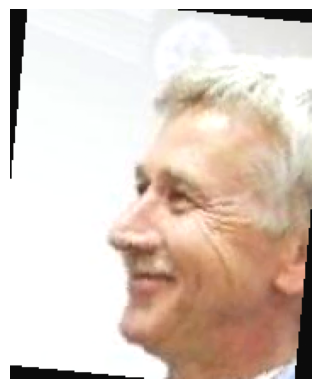

In [25]:
def get_embedding(model, x):
    """
    Extract embedding from the second-to-last layer of ResNet50.
    """
    with torch.no_grad():
        features = model(x)
        features = features.squeeze(-1).squeeze(-1)  # Remove unnecessary dimensions
    return features

# Example usage

import torch
import torch.nn as nn

def get_nth_to_last_embedding(model, x, n=2):
    """
    Extract embedding from the n-th to last layer of ResNet.
    Args:
        model: ResNet model (e.g., ResNet50)
        x: Input image tensor (batch_size, 3, H, W)
        n: Number of layers to remove from the end (default: 2 for second-to-last layer)
    Returns:
        features: Extracted feature tensor
    """
    # Get model layers except last n layers
    truncated_model = nn.Sequential(*list(model.children())[:-n])
    
    with torch.no_grad():
        features = truncated_model(x)  # Pass input through the truncated model
        features = features.squeeze(-1).squeeze(-1)  # Remove unnecessary dimensions

    return features

# Example usage:
# x = torch.randn(1, 3, 224, 224).to(device)  # Example input
# embedding = get_nth_to_last_embedding(model, x, n=2)  # Extract second-to-last layer
# print(embedding.shape)

get_embedding = lambda model, x: get_nth_to_last_embedding(model, x, n=1)


import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

def show_image(tensor_img):
    """
    Displays an image from a tensor.
    """
    if isinstance(tensor_img, torch.Tensor):
        tensor_img = tensor_img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Normalize range from [-1, 1] to [0, 1] if needed
    tensor_img = (tensor_img * 0.5) + 0.5  # Assuming CelebA normalization [-1,1] -> [0,1]
    tensor_img = tensor_img.clip(0, 1)

    plt.imshow(tensor_img)
    plt.axis("off")
    plt.show()

# Example usage
index = 12  # Change index as needed
img_tensor = train_dataset[index][0]  # Get image tensor
show_image(img_tensor)


Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
-----2-----
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
Accuracy of logistic regression on embeddings for with_attr: 0.3675
embedding shape (2000, 2048)
n 1000


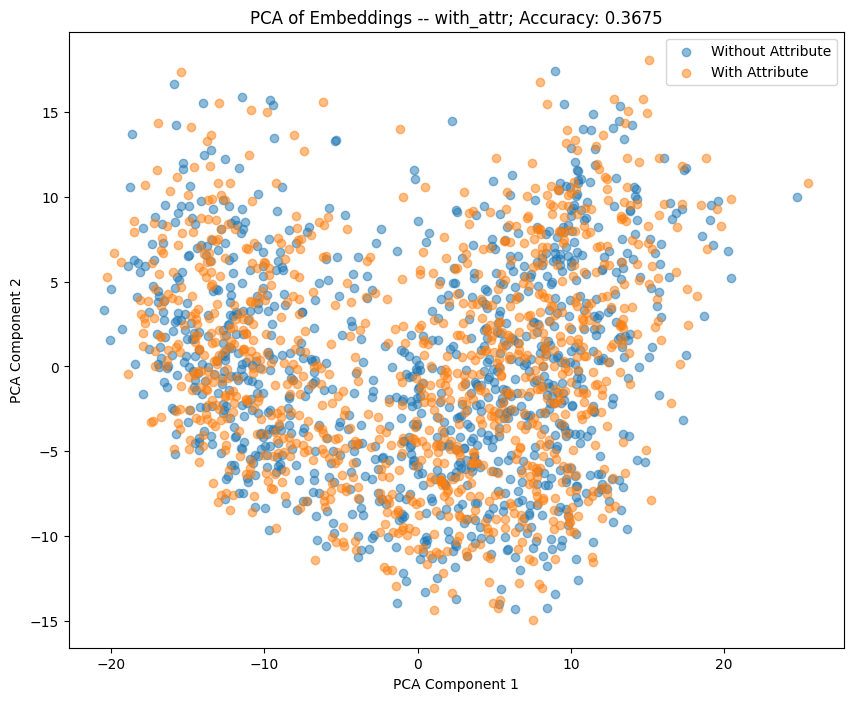

Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
-----2-----
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
Accuracy of logistic regression on embeddings for without_attr: 0.4200
embedding shape (2000, 2048)
n 1000


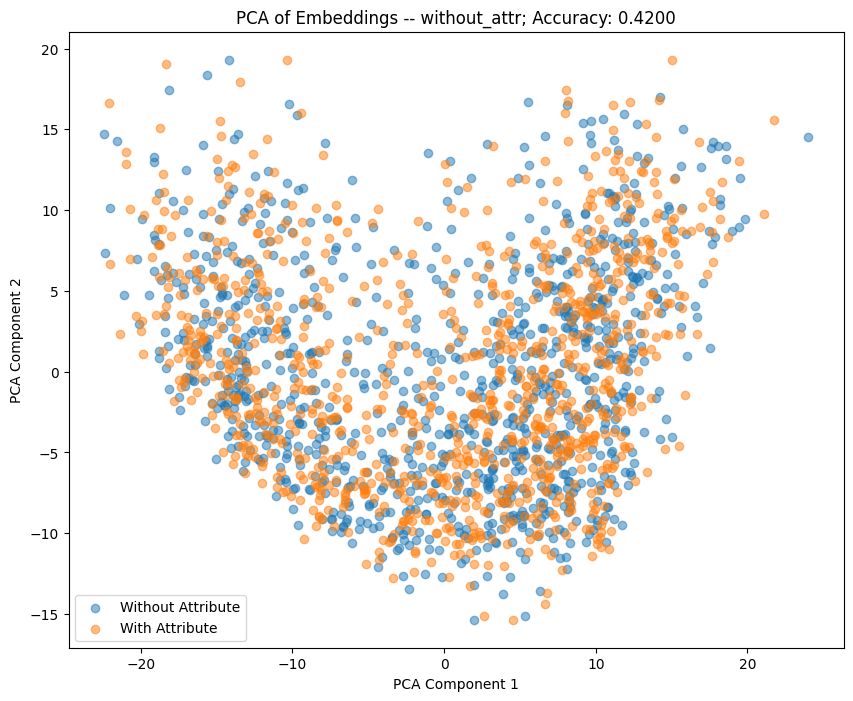

In [29]:
model_ = model 
model_ = model_without_attr
cpu_device = torch.device("cpu")

models = [("with_attr", model), ("without_attr", model_without_attr)]
for name, model_ in models:
    indices_without_attr = np.where(subset_targets_np[:, attr_index] == 0)[0]
    indices_with_attr = np.where(subset_targets_np[:, attr_index] == 1)[0]

    num_images = 1000
    # Get embeddings for images without attribute
    embeddings_without_attr = []
    for ii, idx in enumerate(indices_without_attr[:num_images]):
        if ii % 50 == 0:
            print("Processing sample", ii)
        img_tensor = train_dataset[idx][0].unsqueeze(0).to(cpu_device)  # Add batch dimension
        embedding = get_embedding(model_.to(cpu_device), img_tensor)
        embeddings_without_attr.append(embedding.cpu().numpy())
    print("-----2-----")
    # Get embeddings for images with attribute
    embeddings_with_attr = []
    for ii, idx in enumerate(indices_without_attr[:num_images]):
        if ii % 50 == 0:
            print("Processing sample", ii)
        img_tensor = train_dataset[idx][0].unsqueeze(0).to(cpu_device)  # Add batch dimension
        embedding = get_embedding(model_.to(cpu_device), img_tensor)
        embeddings_with_attr.append(embedding.cpu().numpy())
    all_embeddings = embeddings_without_attr + embeddings_with_attr
    # stack
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    labels_ = np.concatenate([np.zeros(len(embeddings_without_attr)), np.ones(len(embeddings_with_attr))])


    # train logistic regression on embeddings and labels
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import train_test_split
    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(all_embeddings, labels_, test_size=0.2, random_state=42)
    # train logistic regression
    logreg = LogisticRegression(max_iter=1000, solver="liblinear")
    logreg.fit(X_train, y_train)
    preds = logreg.predict(X_test)
    acc = accuracy_score(y_test, preds)

    #acc = accuracy_score(labels_, preds)
    print(f"Accuracy of logistic regression on embeddings for {name}: {acc:.4f}")
    print(f"embedding shape {all_embeddings.shape}")
    n = len(embeddings_with_attr)
    print(f"n {n}")
    # run PCA on embeddings
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import numpy as np
    #embeddings_without_attr_np = np.concatenate(embeddings_without_attr, axis=0)
    #embeddings_with_attr_np = np.concatenate(embeddings_with_attr, axis=0)
    #embeddings_with_attr_np.shape
    # plot embeddings with PCA
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(all_embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_embeddings[:n, 0], pca_embeddings[:n, 1], label="Without Attribute", alpha=0.5)
    plt.scatter(pca_embeddings[n:, 0], pca_embeddings[n:, 1], label="With Attribute", alpha=0.5)
    plt.title(f"PCA of Embeddings -- {name}; Accuracy: {acc:.4f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()
